In [1]:
! pip install atomic
! pip install chess

import argparse
import chess
import MCTS
import torch
import AlphaZeroNetwork
import time



  Preparing metadata (setup.py) ... done
  Created wheel for atomic: filename=atomic-0.7.3-cp39-cp39-linux_x86_64.whl size=26987 sha256=fc3643e1532f20eaf3c6a469c3a708226e96e91dd0bc3f699044a0003cbf7791
  Stored in directory: /root/.cache/pip/wheels/d4/25/e6/a30e521556b4fc888653029fc756f94e21c613fee6fddffcd1
Successfully built atomic
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 10.7 MB/s eta 0:00:00


In [2]:
import math

def calcUCT( edge, N_p ):
    """
    Calculate the UCT formula.

    Args:
        edge (Edge) the edge which the UCT formula is for
        N_p (float) the parents visit count

    Returns:
        (float) the calculated value
    """

    Q = edge.getQ()
    N_c = edge.getN()
    P = edge.getP()

    C = 1.5

    UCT = Q + P * C * math.sqrt( N_p ) / ( 1 + N_c )
    assert not math.isnan( UCT ), 'Q {} N_c {} P {}'.format( Q, N_c, P )
    
    return UCT



In [ ]:

def tolist(board, move_generator ):
    """
    Change an iterable object of moves to a list of moves.
    
    Args:
        move_generator (Mainline object) iterable list of moves

    Returns:
        moves (list of chess.Move) list version of the input moves
    """
    moves = []
    for move in move_generator:
        moves.append( board.san(move) )
    return moves


In [4]:
alphaZeroNet = AlphaZeroNetwork.AlphaZeroNet(20, 256)
weights = torch.load("AlphaZeroNet_20x256.pt")
alphaZeroNet.load_state_dict( weights )
alphaZeroNet = alphaZeroNet.cuda()
for param in alphaZeroNet.parameters():
    param.requires_grad = False
alphaZeroNet.eval()

AlphaZeroNet(
  (convBlock1): ConvBlock(
    (conv1): Conv2d(16, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
  )
  (residualBlocks): ModuleList(
    (0): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [30]:
import chess.svg
from IPython.display import SVG, display

def main(mode, color, num_rollouts, num_threads, fen, verbose ):
    if fen:
        board = chess.Board( fen )
    else:
        board = chess.Board()

    #play chess moves
    while True:
        if board.is_game_over():
            #If the game is over, output the winner and wait for user input to continue
            print( 'Game over. Winner: {}'.format(board.result()))
            board.reset_board()
            c = input( 'Enter any key to continue ' )

        #Print the current state of the board
        if board.turn:
            print('White\'s turn')
        else:
            print('Black\'s turn')
        svg = chess.svg.board(board=board, size=300)
        display(SVG(svg))

        if mode == 'h' and board.turn == color:
            #If we are in human mode and it is the humans turn, play the move specified from stdin
            move_list = tolist( board.legal_moves )

            idx = -1
            while not (0 <= idx and idx < len( move_list ) ):
                string = input( 'Choose a move ' )
                for i, move in enumerate( move_list ):
                    if str( move ) == string:
                        idx = i
                        break
            
            board.push(move_list[idx])

        else:
            # In all other cases the AI selects the next move
            starttime = time.perf_counter()
            with torch.no_grad():
                root = MCTS.Root( board, alphaZeroNet )
                for i in range( num_rollouts ):
                    root.parallelRollouts( board.copy(), alphaZeroNet, num_threads )

            endtime = time.perf_counter()
            elapsed = endtime - starttime
            Q = root.getQ()
            N = root.getN()
            nps = N / elapsed
            same_paths = root.same_paths
    
            if verbose:
                # In verbose mode, print some statistics
                print( root.getStatisticsString() [0])
                print( 'total rollouts {} Q {:0.3f} duplicate paths {} elapsed {:0.2f} nps {:0.2f}'.format( int( N ), Q, same_paths, elapsed, nps ) )
            
            edge = root.maxNSelect()
            bestmove = edge.getMove()
            print( 'best move {}'.format( str( bestmove ) ) )
            board.push( bestmove )
            
            """ MY OVER COMPLICATED ALGORITHM I made since last model was innacurate. Now it's OK
            UCT = {x["UCT"]:x["move"] for x in data}
            PROBABILITIES = {x["P"]:x["move"] for x in data}
            G = sorted(PROBABILITIES.keys(), reverse=True) # All probablitilies from high to low

            highest_uct = root.UCTSelect()
            highest_p = root.maxPSelect()

            if highest_p == highest_uct or (highest_p.getP() - G[1]) <= .1:
                bestmove = highest_uct.getMove()
                print( 'best move {}'.format( str( bestmove ) ), highest_p.getP(), G[1])
                board.push( bestmove )
            elif highest_uct != highest_p:
                for n, uct_item in enumerate(sorted(UCT.keys(), reverse=True)): # Go through all UCT from high to low
                    if n == 0: # Pass if it's the highest since it's already been checked
                        pass
                    else:
                        
                        if PROBABILITIES[G[0]] == UCT[uct_item]: # Check if `n` highest UCT is the highest probability
                            print( 'best move {}'.format( str( UCT[uct_item] ) ) )
                            board.push( UCT[uct_item] )

                                
                        # High UCT + High Prob? Go ahead
                        # High UCT but low prob?
                            # Check if next highest UCT is the highest prob
                                # Go ahead
                            # Keep going until its found
            """

        if mode == 'p':
            #In profile mode, exit after the first move
            break

In [6]:
def parseColor( colorString ):
    """
    Maps 'w' to True and 'b' to False.
    Args:
        colorString (string) a string representing white or black
    """

    if colorString == 'w' or colorString == 'W':
        return True
    elif colorString == 'b' or colorString == 'B':
        return False
    else:
        print( 'Unrecognized argument for color' )
        exit()

White's turn


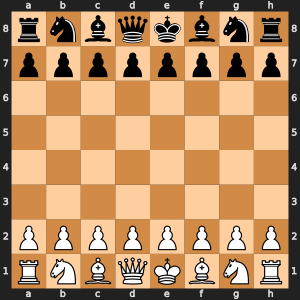

Black's turn


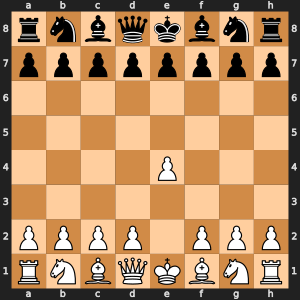

KeyboardInterrupt: 

In [32]:

main(
    mode="h", # Human
    color=parseColor("w"), # White
    num_rollouts=390,
    num_threads=10,
    fen="",
    verbose=False,
)
